> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

## Hybrid Model (CNN-LSTM)
This hand on is to demonstrate the proccess of building Hybrid model (CNN-LSTM) for time series. This hand on consist of two main part which are :
1. Demostration proccess of building Hybrid model in synthetic data
2. Apply the process in shampoo-sales data 

First , let us import the packages needed for this hands on 

In [1]:
#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import math

First , let us create function needed for this hands on :
1. Data sequecing function - use to sequence the data in x-features and y-label 
2. Training function

In [2]:
#Data sequencing function 
def univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Training Function
def training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
        #     Don't do this if you want your LSTM to be stateful
        #     model.hidden = model.init_hidden()
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to perform MSE
            y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0], train_Y.shape[1]))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            running_loss_train += loss_train.item()

        epoch_loss_train = running_loss_train / len(train_X)
        train_loss[t] = epoch_loss_train

        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to perform MSE
                y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], test_Y.shape[1]))
                loss_test = loss_fn(y_test_pred, test_Y)
                running_loss_valid += loss_test.item()

        epoch_loss_test = running_loss_valid / len(test_X)

        val_loss[t] = epoch_loss_test

    return train_loss, val_loss

## Hyperparameter

In [3]:
split_ratio = 0.70
num_epochs = 60
window_size = 3
batch_size = 1
learning_rate=0.01
#seed
torch.manual_seed(123)

## Data Preparation

### Create synthetic data  

In [4]:
#Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])
print(univariate_series.shape)
univariate_series

(40,)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

### Data Spliting 

In [5]:
split_data = round(len(univariate_series)*split_ratio)
split_data

28

In [6]:
#split data by indexing 
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


### Feature Scaling
Use MinMaxScaler to normalize the data into range of value 0 to 1

In [8]:
scaler = MinMaxScaler().fit(train_data.reshape(-1, 1))
train_data_normalized = scaler.transform(train_data.reshape(-1, 1))

test_data_normalized = scaler.transform(test_data.reshape(-1, 1))

### Data Sequencing 

In [9]:
trainX ,trainY =  univariate_single_step(train_data_normalized,window_size)
testX , testY = univariate_single_step(test_data_normalized,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(25, 3, 1) trainY shape:(25, 1)

testX shape:(9, 3, 1) testY shape:(9, 1)


### Data Transform 
Transform the data into pytorch tensor

In [10]:
#transfrom to Pytorch tensor
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([25, 3, 1]) trainY shape:torch.Size([25, 1])

testX shape:torch.Size([9, 3, 1]) testY shape:torch.Size([9, 1])


### Data Transpose 
Transpose the data from (batch size,sequence_length, n_timeseries) into (batch size, n_timeseries , sequence_length)

In [11]:
# Data Transpose
trainX = torch.transpose(trainX, 1, 2)
testX = torch.transpose(testX, 1, 2)

### Data Iterator 

In [12]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=1,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=1,shuffle=False)

## CNN-LSTM Configuration 
First , CNN configuration such as number of input channel,output channel,number of layer need to be define in the class CNN.Then the LSTM configuration is define and the CNN class is call in class Combine as well.Then a forward function is use to allow the data flow into CNN first continue by the LSTM. 

![CNN-LSTM](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/07/Convolutional-Neural-Network-Long-Short-Term-Memory-Network-Archiecture.png)

In [13]:
class CNN(nn.Module):
    def __init__(self,n_timeseries,n_out_dim):
        super(CNN, self).__init__()
        self.n_timeseries = n_timeseries
        self.n_out_dim = n_out_dim
        self.conv1 = nn.Conv1d(in_channels = n_timeseries,out_channels=10, kernel_size=2)
        self.poo1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, n_out_dim)

    def forward(self, x):
        x = self.poo1(F.relu(self.conv1(x)))
        x = x.view(-1, 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class Combine(nn.Module):
    def __init__(self,n_timeseries,n_output,hidden_size=64):
        super(Combine, self).__init__()
        self.n_timeseries = n_timeseries
        self.n_output = n_output
        self.hidden_size = hidden_size
        self.num_layers = 1

        self.cnn = CNN(n_timeseries,n_output)

        self.lstm = nn.LSTM(
            input_size= n_timeseries,
            hidden_size= hidden_size,
            num_layers=1,
            batch_first=True)
        self.linear = nn.Linear(hidden_size,n_output)

    def forward(self, x):
        c_out = self.cnn(x)

        # Reshape the c_out to fit in LSTM
        c_out = torch.reshape(c_out,(c_out.shape[0],c_out.shape[1],1))

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, (hn, cn) = self.lstm(c_out, (h0.detach(), c0.detach()))
        out = self.linear(out)

        return (out[:, -1, :])

## Input Model

In [14]:
model = Combine(n_timeseries=trainX.shape[1],n_output=1)
print(model.eval())

#loss function
loss_fn = torch.nn.MSELoss()

#optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)



Combine(
  (cnn): CNN(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


## Weight Initialization 

In [15]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

Combine(
  (cnn): CNN(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## Training

In [16]:
# Start Training 
train_loss, val_loss = training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model)

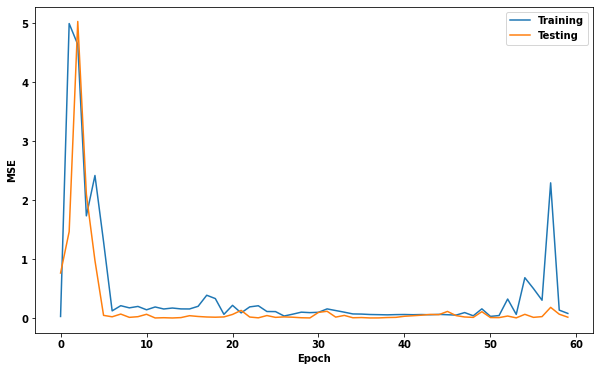

In [17]:
# Create Learining Curve 
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Learning Curve")
plt.legend()
plt.show()

## Forecast 

In [18]:
# make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

In [19]:
# Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction, (y_train_prediction.shape[0], y_train_prediction.shape[1]))
trainY = torch.reshape(trainY, (trainY.shape[0], trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction, (y_test_prediction.shape[0], y_test_prediction.shape[1]))
testY = torch.reshape(testY, (testY.shape[0], testY.shape[1]))

In [20]:
# Invert the scaled data back to original
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [201]:
print("Test Data \tForecast")
for i in range(len(y_test_prediction)):   
    print(f"{int(y_test[i])}\t\t{int(y_test_prediction[i])}")

Test Data 	Forecast
310		326
320		335
330		343
340		351
349		358
360		366
370		373
380		379
390		386


In [202]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 29.36 RMSE
Test Score: 10.39 RMSE


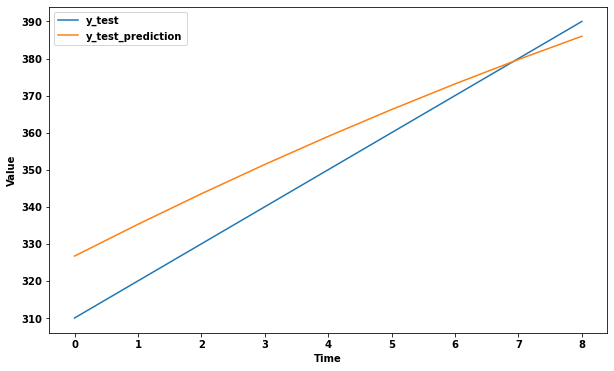

In [203]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label="y_test")
plt.plot(y_test_prediction, label="y_test_prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

# Exercise for Univariate (Solution)
Use CNN to predict the sales of shampoo \
Data Sources : https://www.kaggle.com/djokester/sales-of-shampoo-over-a-three-year-period

## Hyperparameter

In [175]:
#Hyperparameter
num_epochs_shampoo = 700
split_ratio = 0.70
batch_size_shampoo = 1
window_size_shampoo = 3
learning_rate_shampoo = 0.001
#Hidden Layer for LSTM
hidden_dim = 64

#seed
torch.manual_seed(123)

## Data Preparation

In [176]:
shampoo = pd.read_csv('../../datasets/others/shampoo-sales.csv')
shampoo_ts =shampoo['sales']
shampoo_ts.head()

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
Name: sales, dtype: float64

## Feature Scaling 

In [178]:
scaler_shampoo = MinMaxScaler().fit(shampoo_ts.values.reshape(-1,1))
shampoo_data = scaler_shampoo.transform((shampoo_ts.values.reshape(-1,1)))

##  Data Splitting 

In [177]:
split_data = round(len(shampoo_ts)*split_ratio)
split_data

25

In [179]:
train_data_shampoo = shampoo_data[:split_data]
test_data_shampoo = shampoo_data[split_data:]
train_time = shampoo_ts.index[:split_data]
test_time = shampoo_ts.index[split_data:]
print("train_data_shampoo_shape")
print(train_data_shampoo.shape)
print("test_data_shampoo_shape")
print(test_data_shampoo.shape)

train_data_shampoo_shape
(25, 1)
test_data_shampoo_shape
(11, 1)


## Data Sequencing 

In [180]:
#Data Sequencing 
trainX_shampoo ,trainY_shampoo =  univariate_single_step(train_data_shampoo,window_size_shampoo)
testX_shampoo , testY_shampoo = univariate_single_step(test_data_shampoo,window_size_shampoo)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:(22, 3, 1) trainY shape:(22, 1)

testX shape:(8, 3, 1) testX shape:(8, 1)


## Data Transform
Transform the data into pytorch tensor

In [181]:
#Transfrom numpy to Pytorch tensor
# make training and test sets in torch
trainX_shampoo = torch.from_numpy(trainX_shampoo).type(torch.Tensor)
trainY_shampoo = torch.from_numpy(trainY_shampoo).type(torch.Tensor)
testX_shampoo = torch.from_numpy(testX_shampoo).type(torch.Tensor)
testY_shampoo = torch.from_numpy(testY_shampoo).type(torch.Tensor)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:torch.Size([22, 3, 1]) trainY shape:torch.Size([22, 1])

testX shape:torch.Size([8, 3, 1]) testX shape:torch.Size([8, 1])


## Data Transpose
Transpose the data into (Batch size , n_timeseries, sequence_length )

In [182]:
# Data Transpose
trainX_shampoo = torch.transpose(trainX_shampoo, 1, 2)
testX_shampoo  = torch.transpose(testX_shampoo,1, 2)

## Data Iterator 

In [183]:
# Create Iterator
train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)
train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

test_dataset_shampoo = TensorDataset(testX_shampoo, testY_shampoo)
test_iter_shampoo = DataLoader(test_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

## Import Model 

In [205]:
model_shampoo  = Combine(n_timeseries=trainX_shampoo.shape[1],n_output=1)
print(model_shampoo.eval())

#loss function
loss_fn_shampoo = torch.nn.MSELoss()

#optimiser
optimiser_shampoo = torch.optim.Adam(model_shampoo.parameters(), lr=learning_rate_shampoo)

Combine(
  (cnn): CNN(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


## Weight Initialization 

In [185]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model_shampoo.apply(weights_init)

Combine(
  (cnn): CNN(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## Training 

In [186]:

train_loss_shampoo,val_loss_shampoo = training(num_epochs_shampoo,train_iter_shampoo,test_iter_shampoo,optimiser_shampoo,loss_fn_shampoo,model_shampoo)

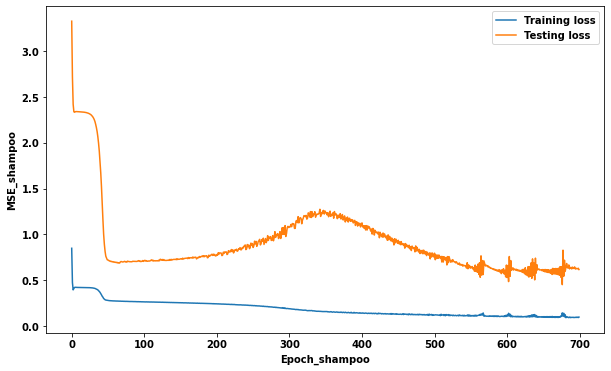

In [187]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo, label="Training loss")
plt.plot(val_loss_shampoo, label="Testing loss")
plt.xlabel("Epoch_shampoo")
plt.ylabel("MSE_shampoo")
plt.title("Learning Curve")
plt.legend()
plt.show()

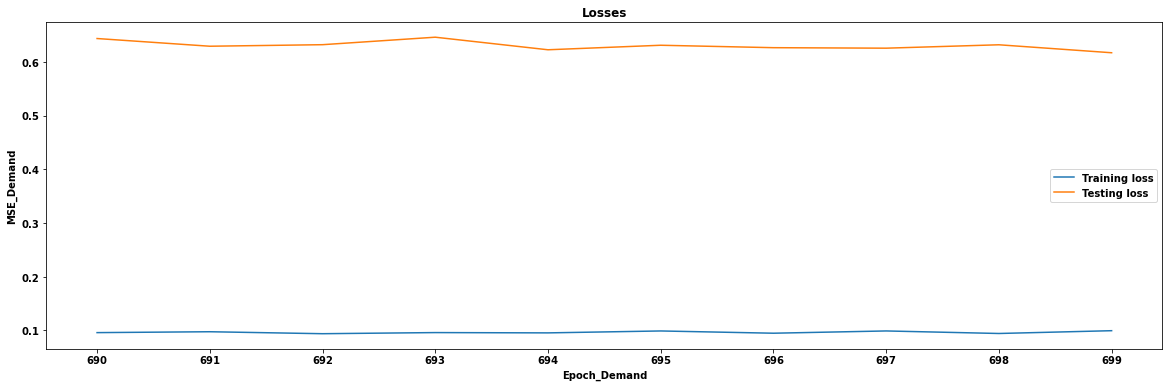

In [206]:
# Zoom in by fill in start_epoch and end_epoch due the learning is scaled and hard to visualize 
start_epoch = 690
end_epoch = 700
plt.figure(figsize=(20,6))
plt.plot(train_loss_shampoo[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_shampoo[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

## Inference

In [189]:
#Make predictions
y_train_prediction_shampoo= model_shampoo(trainX_shampoo)
y_test_prediction_shampoo= model_shampoo(testX_shampoo)

#Reshape to original data
y_train_prediction_shampoo = torch.reshape(y_train_prediction_shampoo,(y_train_prediction_shampoo.shape[0],y_train_prediction_shampoo.shape[1]))
trainY_shampoo = torch.reshape(trainY_shampoo,(trainY_shampoo.shape[0],trainY_shampoo.shape[1]))
y_test_prediction_shampoo = torch.reshape(y_test_prediction_shampoo,(y_test_prediction_shampoo.shape[0],y_test_prediction_shampoo.shape[1]))
testY_shampoo = torch.reshape(testY_shampoo,(testY_shampoo.shape[0],testY_shampoo.shape[1]))

In [190]:
#Invert predictions
y_train_pred_shampoo = scaler_shampoo.inverse_transform(y_train_prediction_shampoo.detach().numpy())
y_train_shampoo = scaler_shampoo.inverse_transform(trainY_shampoo.detach().numpy())
y_test_pred_shampoo = scaler_shampoo.inverse_transform(y_test_prediction_shampoo.detach().numpy())
y_test_shampoo = scaler_shampoo.inverse_transform(testY_shampoo.detach().numpy())

In [207]:
print("Test Data\t\tForecast")
for i in range(len(y_test_shampoo)):
    print(f"{y_test_shampoo[i]}\t\t{y_test_pred_shampoo[i]}")

Test Data		Forecast
[401.3]		[354.61572]
[437.4]		[333.99084]
[575.5]		[400.11447]
[407.59998]		[323.59378]
[682.]		[424.389]
[475.3]		[351.96713]
[581.30005]		[390.91815]
[646.89996]		[482.895]


In [192]:
#calculate root mean squared error
trainScore_shampoo = math.sqrt(mean_squared_error(y_train_shampoo[:,0], y_train_pred_shampoo[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_shampoo))
testScore_shampoo = math.sqrt(mean_squared_error(y_test_shampoo[:,0], y_test_pred_shampoo[:,0]))
print('Test Score: %.2f RMSE' % (testScore_shampoo))

Train Score: 34.50 RMSE
Test Score: 156.29 RMSE


In [193]:
# Adjust to make the sequence data plot on original test data 
a=range(split_data+window_size_shampoo,split_data+len(y_test_shampoo)+window_size_shampoo)

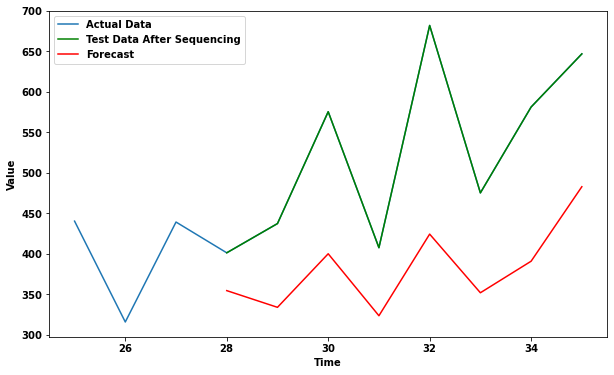

In [194]:
test_data_shampoo = scaler_shampoo.inverse_transform(test_data_shampoo)
plt.figure(figsize=(10,6))
plt.plot(test_time,test_data_shampoo, label = 'Actual Data')
plt.plot(a,y_test_shampoo, color="green",label = 'Test Data After Sequencing')
plt.plot(a,y_test_pred_shampoo,color="red", label = 'Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

## Reference
1. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee
2. https://www.kaggle.com/hanjoonchoe/cnn-time-series-forecasting-with-pytorch